From the paper we aim to reproduce and extend, we learn that the BKF MAP estimator is equivalent to universal soft thresholding, given the following condtions
- $\frac{\sigma_{\theta}^2}{c} = log N$ 
- $\alpha \to 1$
or large $N$.

In [76]:
import numpy as np
import pywt

def universal_soft_thresholding(image, wavelet='db4', level=1, mode='periodization'):
    # 2D wavelet decomposition
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level, mode=mode)

    # --- Estimate sigma from finest-level HH band (cD1) ---
    cH1, cV1, cD1 = coeffs[-1]
    sigma = np.median(np.abs(cD1)) / 0.6745
    sigma = max(sigma, 1e-10)  # avoid zero sigma

    def soft(c, T):
        return np.sign(c) * np.maximum(np.abs(c) - T, 0)

    # new coeff list, copy approximation
    new_coeffs = [coeffs[0]]

    # apply thresholding at each level
    for (cH, cV, cD) in coeffs[1:]:
        # band-size dependent universal threshold
        N_band = cH.size + cV.size + cD.size   
        T = sigma * np.sqrt(2 * np.log(N_band))

        cH_t = soft(cH, T)
        cV_t = soft(cV, T)
        cD_t = soft(cD, T)

        new_coeffs.append((cH_t, cV_t, cD_t))

    # reconstruct
    denoised = pywt.waverec2(new_coeffs, wavelet=wavelet, mode=mode)
    return denoised


In [77]:
#now need a function to run universal_soft_thresholding using db4, sym4, and coif4 wavelets
def run_thresholding_with_wavelets(data, wavelets=['db4', 'sym4', 'coif4'], level=1):
    results = {}
    for wavelet in wavelets:
        denoised_data = universal_soft_thresholding(data, wavelet=wavelet, level=level)
        results[wavelet] = denoised_data
    return results


In [78]:
#COPYING A BUNCH OF FUNCTIONS FROM BKFALGORITHMS 
def add_noise(img, SNR_dB, noise_type='gaussian'):
    signal_power = np.mean(img ** 2)
    noise_power = signal_power / (10 ** (SNR_dB / 10))
    if noise_type == 'poisson':
      lamda = np.power(10,SNR_dB/10)/np.mean(img)
      scaled = img * lamda
      noisy_counts = np.random.poisson(scaled)
      noisy = noisy_counts / lamda
    else:
        noise = np.random.normal(0, np.sqrt(noise_power), img.shape)
        noisy = img + noise
    return np.clip(noisy, 0, 1)
def estimate_SNR(img, estim_std):
     signal_power = np.mean(img ** 2)
     estim_SNR = 10 * np.log10(signal_power / (estim_std ** 2))
     return estim_SNR
print("Meow")

def get_dHH1_subband(noisy_image, wavelet_name='db4'):

    coeffs = pywt.wavedec2(noisy_image, wavelet=wavelet_name, level=1)
    # Unpack the detail coefficients from the tuple
    cA, (cH1, cV1, dHH_1) = coeffs
    
    return dHH_1
def estimate_noise_std(noisy_image, wavelet_name='db4'):
    # extract dHH_1 subband 
    dHH_1 = get_dHH1_subband(noisy_image, wavelet_name=wavelet_name)
    #calculate MAD, we can take this shortcut bc awgn so we assume median is approx 0.
    mad_val = np.median(np.abs(dHH_1))
    #compute sigma_epsilon 
    sigma_epsilon = mad_val / 0.6745
    return sigma_epsilon

Meow


(850, 850)


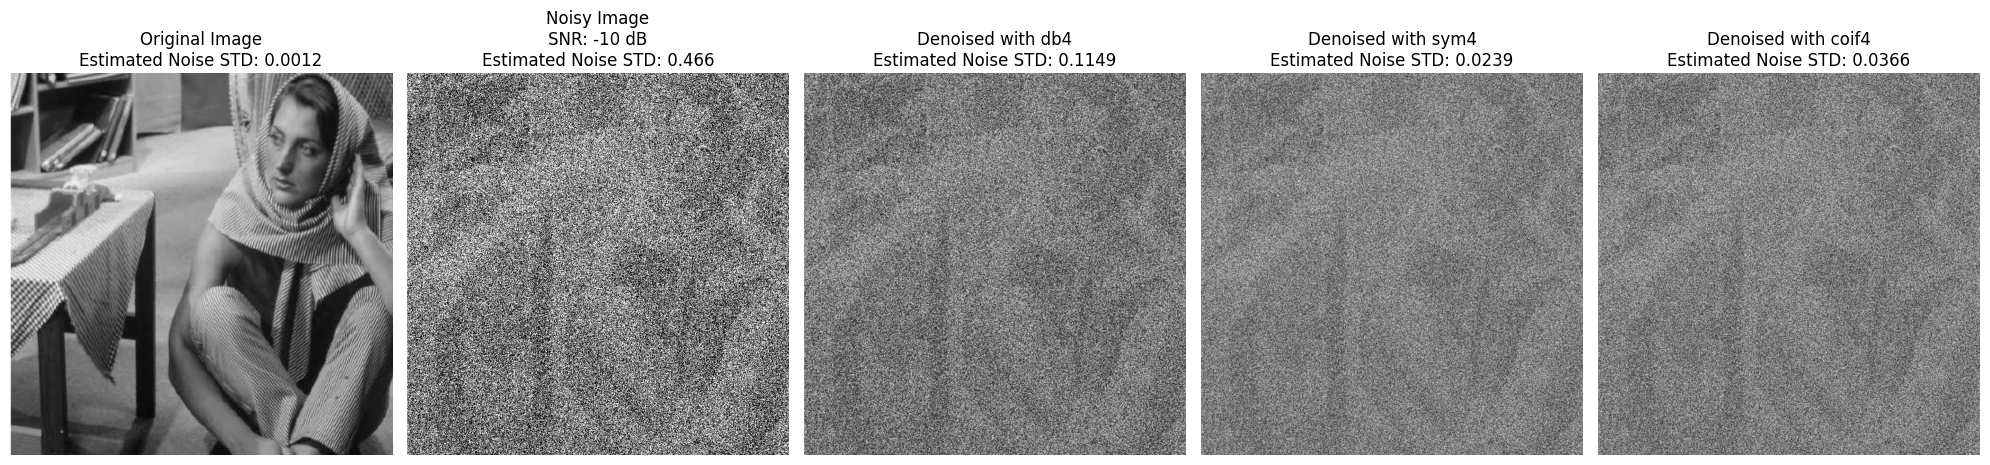

In [ ]:
from skimage import io, util, img_as_float
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


# Load image
img = img_as_float(io.imread("barbara.png"))

# Drop alpha channel if present
if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3]  # keep RGB only

# Convert to grayscale
gray_img = rgb2gray(img)

print(gray_img.shape)



SNR_dB = -10
noisy_img = add_noise(gray_img, SNR_dB, 'gaussian')
original_std = round(estimate_noise_std(gray_img),4)
noisy_std = round(estimate_noise_std(noisy_img),4)
denoised_results = run_thresholding_with_wavelets(noisy_img, wavelets=['db4', 'sym4', 'coif4'], level=2)

#AND NOW PLOTTING RESULTS
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(gray_img, cmap='gray')
axes[0].set_title(f'Original Image\nEstimated Noise STD: {original_std}')
axes[0].axis('off')
axes[1].imshow(noisy_img, cmap='gray')
axes[1].set_title(f'Noisy Image\nSNR: {SNR_dB} dB\nEstimated Noise STD: {noisy_std}')
axes[1].axis('off')
wavelet_titles = ['db4', 'sym4', 'coif4']
for i, wavelet in enumerate(wavelet_titles):
    denoised_img = denoised_results[wavelet]
    denoised_std = round(estimate_noise_std(denoised_img),4)
    axes[i+2].imshow(denoised_img, cmap='gray')
    axes[i+2].set_title(f'Denoised with {wavelet}\nEstimated Noise STD: {denoised_std}')
    axes[i+2].axis('off')
plt.tight_layout()
plt.show()